#HW6
##Author Anita Ahmed - ama908@nyu.edu
###TIME SERIES ANALYSIS
###Goal: Find outliers, trends and periodicity in the MTA turnstile data
###DATA:
###MTA subway fares. It is a complete dataset of rides logged by card swipes for 600 Manhattan stations. It contains 23 different subway card types.


In [131]:
#importing packages
import pylab as pl
import pandas as pd
import numpy as np
import os
import scipy.stats
import matplotlib.pyplot as pl
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [132]:
# Impoting MTA_Fare File
dataset = np.load("MTA_Fare.npy")

dataset = np.array(dataset)
dataset = dataset.astype(numpy.float)
print dataset.shape
print dataset.ndim
print dataset.itemsize
print type(dataset)
print dataset.size

(600L, 23L, 194L)
3
8
<type 'numpy.ndarray'>
2677200


# Task 1:
Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.¶
Identify it and figure out what it is due to.

In [133]:
#converting missing values to NAN
dataset[dataset==-1] = np.nan

In [134]:
# sum time series for all ride types & stations
total_sum =np.nansum(dataset,axis = (0,1))
print total_sum

[ 26720267.  29265971.  29601189.  29387592.  29185768.  26211666.
  28683614.  29125646.  28803814.  28599546.  28312019.  27931015.
  27271701.  28250357.  26687174.  30018756.  30183790.  29052100.
  30068614.  29172431.  30327068.  30190292.  29987273.  30053446.
  30128994.  25164391.  29189219.  30580790.  30106591.  27561217.
  21802973.  21796368.  27483123.  27112540.  26013915.  26433790.
  28660073.  29103923.  29576628.  26721588.  29180204.  29400660.
  29880586.  29677420.  29525360.  30175740.  30196675.  28500091.
  29035465.  30398309.  29992271.  29953470.  27148617.  29850111.
  30165985.  29979266.  30298087.  26744295.  29967687.  29475619.
  29253128.  29429842.  29063294.  27980138.  27924672.  22985008.
  28142943.  31996089.  32506259.  24297825.  32159233.  30747690.
  32641199.  32904387.  31953835.  32131041.  32477470.  27031175.
  31808940.  33123277.  33173847.  31934242.  24565703.  28049643.
  30004428.  28040469.  29387312.  31200600.  31673650.  31126

In [135]:
mean = np.nanmean(total_sum)
std = np.nanstd(total_sum)
print mean, std

29781349.8711 2983960.4217


In [136]:
#calculating thresholds at > 3sigma 
thresholds = [mean - 3*std, 
              mean + 3*std]
print thresholds

[20829468.606031362, 38733231.136236683]


In [137]:
# The date range given in the question is actally  196 weeks so for my analysis, I just removed the first and the last week. 
week_generated = np.arange('2010-05-28', '2014-02-14', dtype='datetime64[W]')

In [138]:
#Event Detection with sigma >3
Event = np.where((total_sum<thresholds[0])|(total_sum>thresholds[1]))
print week_generated[Event]

['2012-10-25']


So we see that an event took place on the week of Oct 25th, 2012. Which is the due to the event of Hurricane sandy that occured between Oct 22 and Oct 31 in 2012. 

# Task 2:
Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [139]:
# Question asked "which rideship type ...", we sum over the stations and reduce the data by a factor 600. 
sum_ridetypes = np.nansum(dataset, axis=(0))
sum_ridetypes.shape

(23L, 194L)

In [140]:
# Type of Rides
ridetypes = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [141]:
#converting the np array to pd dataframe for ease of computation
dateRange = pd.date_range(pd.to_datetime('05/28/2010'), pd.to_datetime('02/14/2014'),freq='W')
ridertypes = pd.DataFrame(np.transpose(sum_ridetypes), index=dateRange)
ridertypes.rename(columns=lambda x: ridetypes[x], inplace=True)
ridertypes.head()

10t     14d     1d      2t    30d       7d      ada   afas  \
2010-05-30  11494615  530524  47801  186551  46808  3697443  8551937  10063   
2010-06-06  12526859  583533  51486  199229  64353  3981808  9486394  11847   
2010-06-13  12766627  586194  51636  199668  56994  4033030  9476538  12277   
2010-06-20  12653675  562602  52063  196389  37429  4032753  9450081  11221   
2010-06-27  12809694  548858  51153  194883  35210  3925446  9294002  10515   

               exp      ez  ...    month     rfm     rr    sen  spec    tcmc  \
2010-05-30  333197  512032  ...   123134  790110  59809  28221     0  124693   
2010-06-06  282755  578023  ...   151948  908068  69209  32333     0  121713   
2010-06-13  302028  615537  ...   151538  914124  69574  32618     0  122181   
2010-06-20  305513  606270  ...   147094  902549  68099  32404     0  122051   
2010-06-27  335780  563446  ...   137888  855573  66377  31933   176  119776   

                t  umlim  xbus  stud  
2010-05-30  21060   6128   358     0  
2010-06-06  21670   6120   474     0  
2010-06-13  21433   6490   465     0  
2010-06-20  21630   6590   484     0  
2010-06-27  20297   6313   452     0  

[5 rows x 23 columns]

In [142]:
# Calulating flux ratio to measure the change in trend of ridership
flux_ratio = ridertypes.head(10).mean()/ridertypes.tail(10).mean()

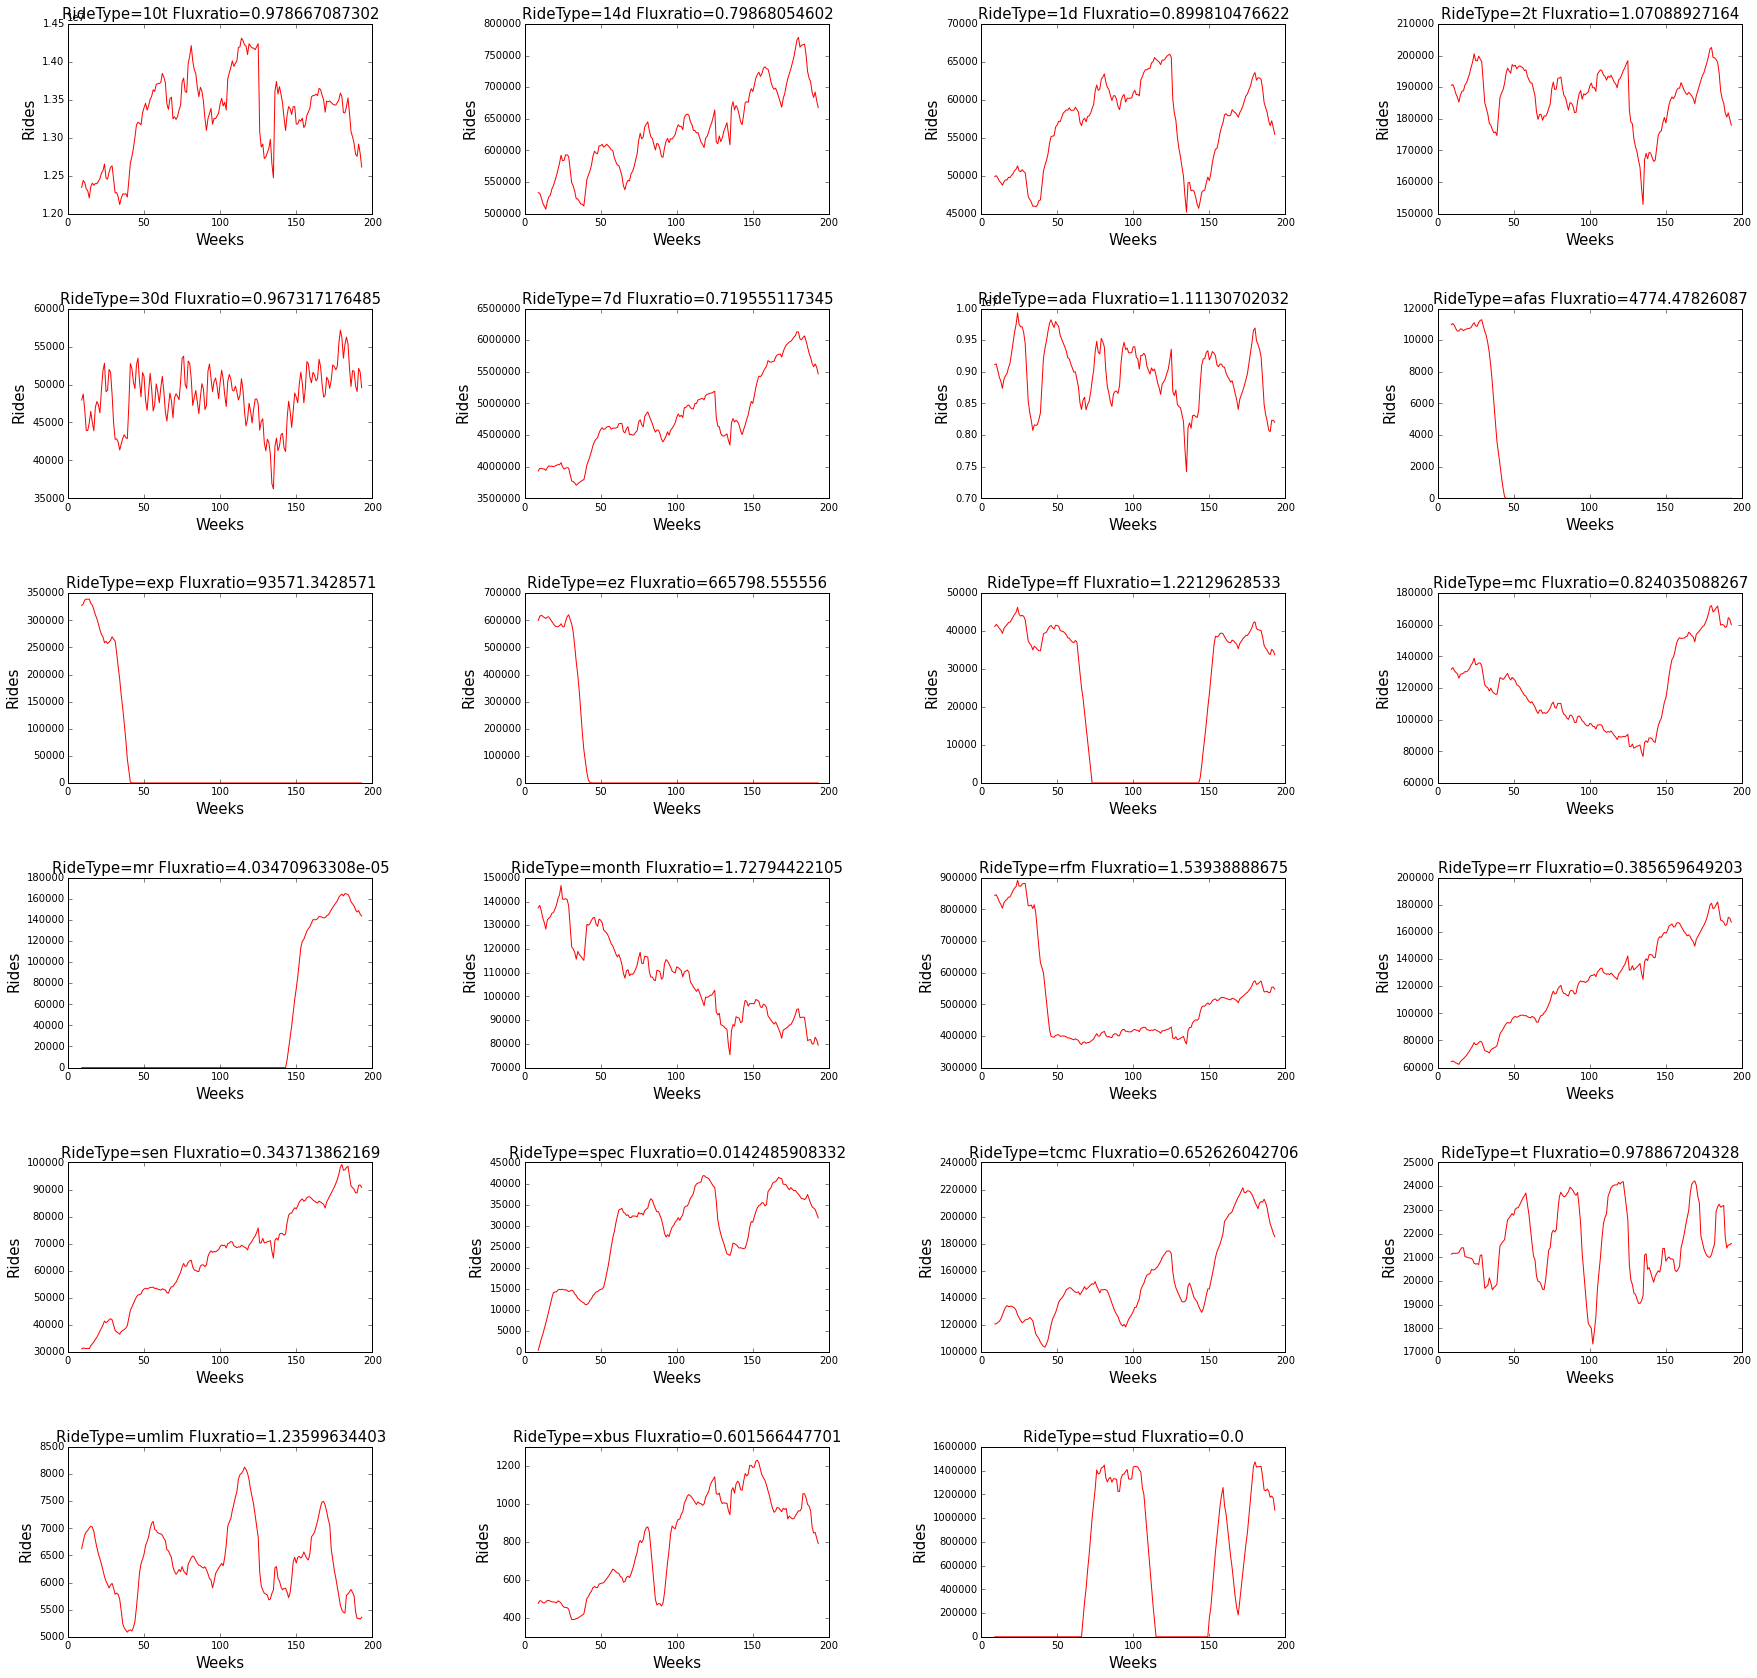

In [143]:
#THE TREND DETECTION for 23 ridertypes over a period of 194 weeks:

fig = pl.figure(figsize=(30,28))
for i in range(0,23):
        ax = fig.add_subplot(6,4,i+1)
        label1 = 'RideType=%s Fluxratio=%s' % (ridetypes[i],flux_ratio[i])
        ax.plot(pd.rolling_mean(ridertypes[ridetypes[i]], 10), color ='r')
        ax.set_xlabel('Weeks',fontsize= 15)
        ax.set_ylabel('Rides',fontsize= 15)
        ax.set_title(label1 ,fontsize= 15)
        pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, bottom=.1)

Use of 14d passes have steadily increased at an approximate rate of 0.798681.
Use of 7d passes have steadily increased at an approximate rate of 0.719555.
Use of rr passes have steadily increased at an approximate rate of 0.385660.
Use of sen passes have steadily increased at an approximate rate of 0.343714.
Use of tcmc passes have steadily increased at an approximate rate of 0.652626.
Use of xbus passes have steadily increased at an approximate rate of 0.601566.


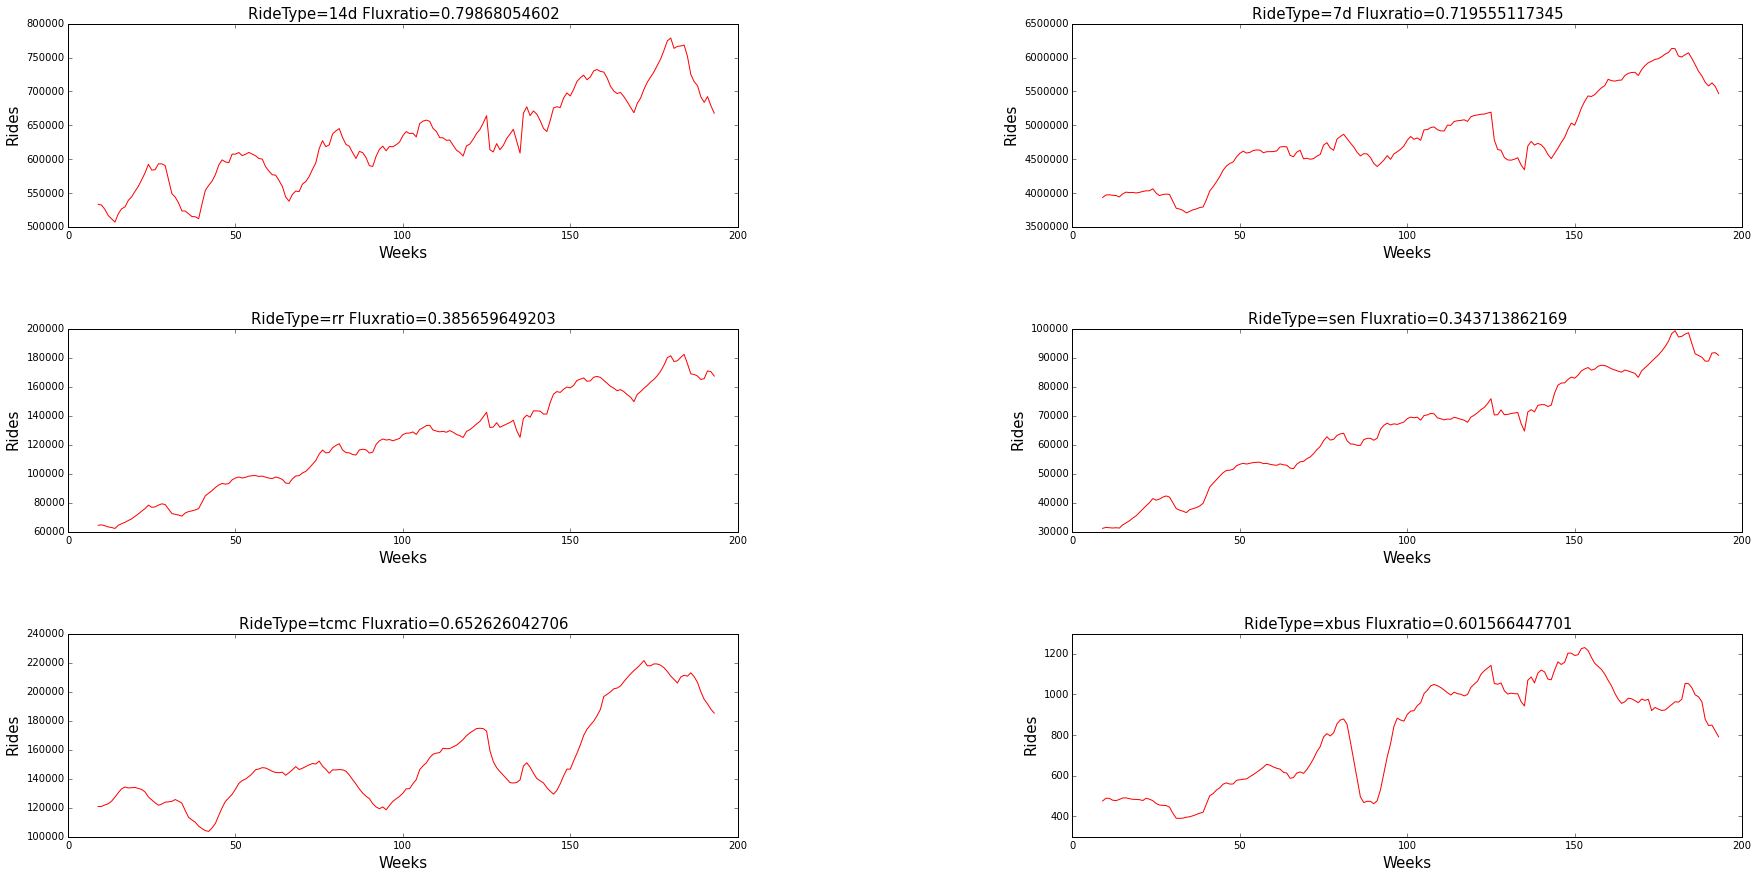

In [144]:
#After observing the plots re-plotting all the stations with steady increase. 
j = []
for i in range(0,23):
    if flux_ratio[i] > .3 and flux_ratio[i] <= 0.8:
        j.append(i)
fig = pl.figure(figsize=(30,30))
for i in range(len(j)):
        print 'Use of %s passes have steadily increased at an approximate rate of %f.' % (ridetypes[j[i]], flux_ratio[j[i]])
        ax = fig.add_subplot(6,2,i+1)
        label1 = 'RideType=%s Fluxratio=%s' % (ridetypes[j[i]],flux_ratio[j[i]])
        ax.plot(pd.rolling_mean(ridertypes[ridetypes[j[i]]], 10), color ='r')
        ax.set_xlabel('Weeks',fontsize= 15)
        ax.set_ylabel('Rides',fontsize= 15)
        ax.set_title(label1,fontsize= 15)
        pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, bottom=.1)

Use of month passes have steadily decreased at an approximate rate of 1.727944.


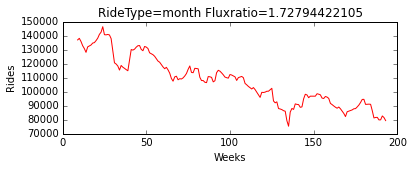

In [145]:
#After observing the plots re-plotting all the stations with steady decrease. 
k = []
for i in range(0,23):
    if flux_ratio[i] > 1.7 and flux_ratio[i] <1.8:
        k.append(i)    
fig = pl.figure(figsize=(6,2))
for i in range(len(k)):
        print 'Use of %s passes have steadily decreased at an approximate rate of %f.' % (ridetypes[k[i]], flux_ratio[k[i]])
        ax = fig.add_subplot(1,1,i+1)
        label1 = 'RideType=%s Fluxratio=%s' % (ridetypes[k[i]],flux_ratio[k[i]])
        ax.plot(pd.rolling_mean(ridertypes[ridetypes[k[i]]], 10), color ='r')
        ax.set_xlabel('Weeks')
        ax.set_ylabel('Rides')
        ax.set_title(label1)

Use of mr passes have been introduced after the first 10 time series.
Use of stud passes have been introduced after the first 10 time series.


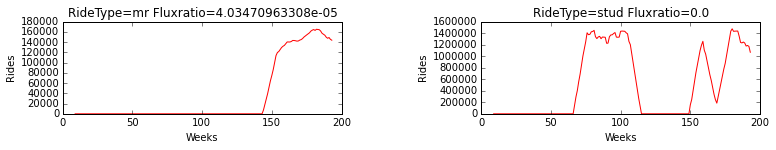

In [183]:
l = []
for i in range(0,23):
    if (flux_ratio[i] >= 0) and (flux_ratio[i] < 0.001) :
        l.append(i)    
fig = pl.figure(figsize=(20,4))
for i in range(len(l)):
        print 'Use of %s passes have been introduced after the first 10 time series.' % (ridetypes[l[i]])
        ax = fig.add_subplot(2,3,i+1)
        label1 = 'RideType=%s Fluxratio=%s' % (ridetypes[l[i]],flux_ratio[l[i]])
        ax.plot(pd.rolling_mean(ridertypes[ridetypes[l[i]]], 10), color ='r')
        ax.set_xlabel('Weeks')
        ax.set_ylabel('Rides')
        ax.set_title(label1)
        pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, bottom=.1)

Use of afas passes experienced steep decrease or are Discontinued.
Use of exp passes experienced steep decrease or are Discontinued.
Use of ez passes experienced steep decrease or are Discontinued.


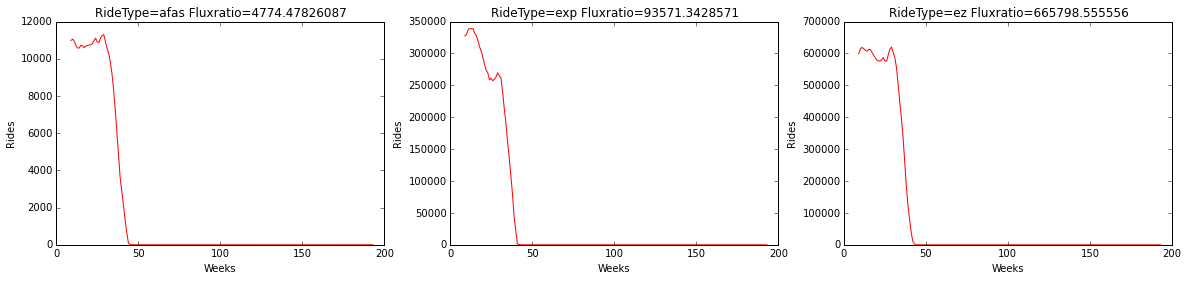

In [182]:
m = []
for i in range(0,23):
    if flux_ratio[i] > 2:
        m.append(i)    
fig = pl.figure(figsize=(20,4))
for i in range(len(m)):
        print 'Use of %s passes experienced steep decrease or are Discontinued.' % (ridetypes[m[i]])
        ax = fig.add_subplot(1,3,i+1)
        label1 = 'RideType=%s Fluxratio=%s' % (ridetypes[m[i]],flux_ratio[m[i]])
        ax.plot(pd.rolling_mean(ridertypes[ridetypes[m[i]]], 10), color ='r')
        ax.set_xlabel('Weeks')
        ax.set_ylabel('Rides')
        ax.set_title(label1)

Use of 10t passes have a complex structure.
Use of 1d passes have a complex structure.
Use of 2t passes have a complex structure.
Use of 30d passes have a complex structure.
Use of ada passes have a complex structure.
Use of ff passes have a complex structure.
Use of mc passes have a complex structure.
Use of mr passes have a complex structure.
Use of rfm passes have a complex structure.
Use of spec passes have a complex structure.
Use of t passes have a complex structure.
Use of umlim passes have a complex structure.


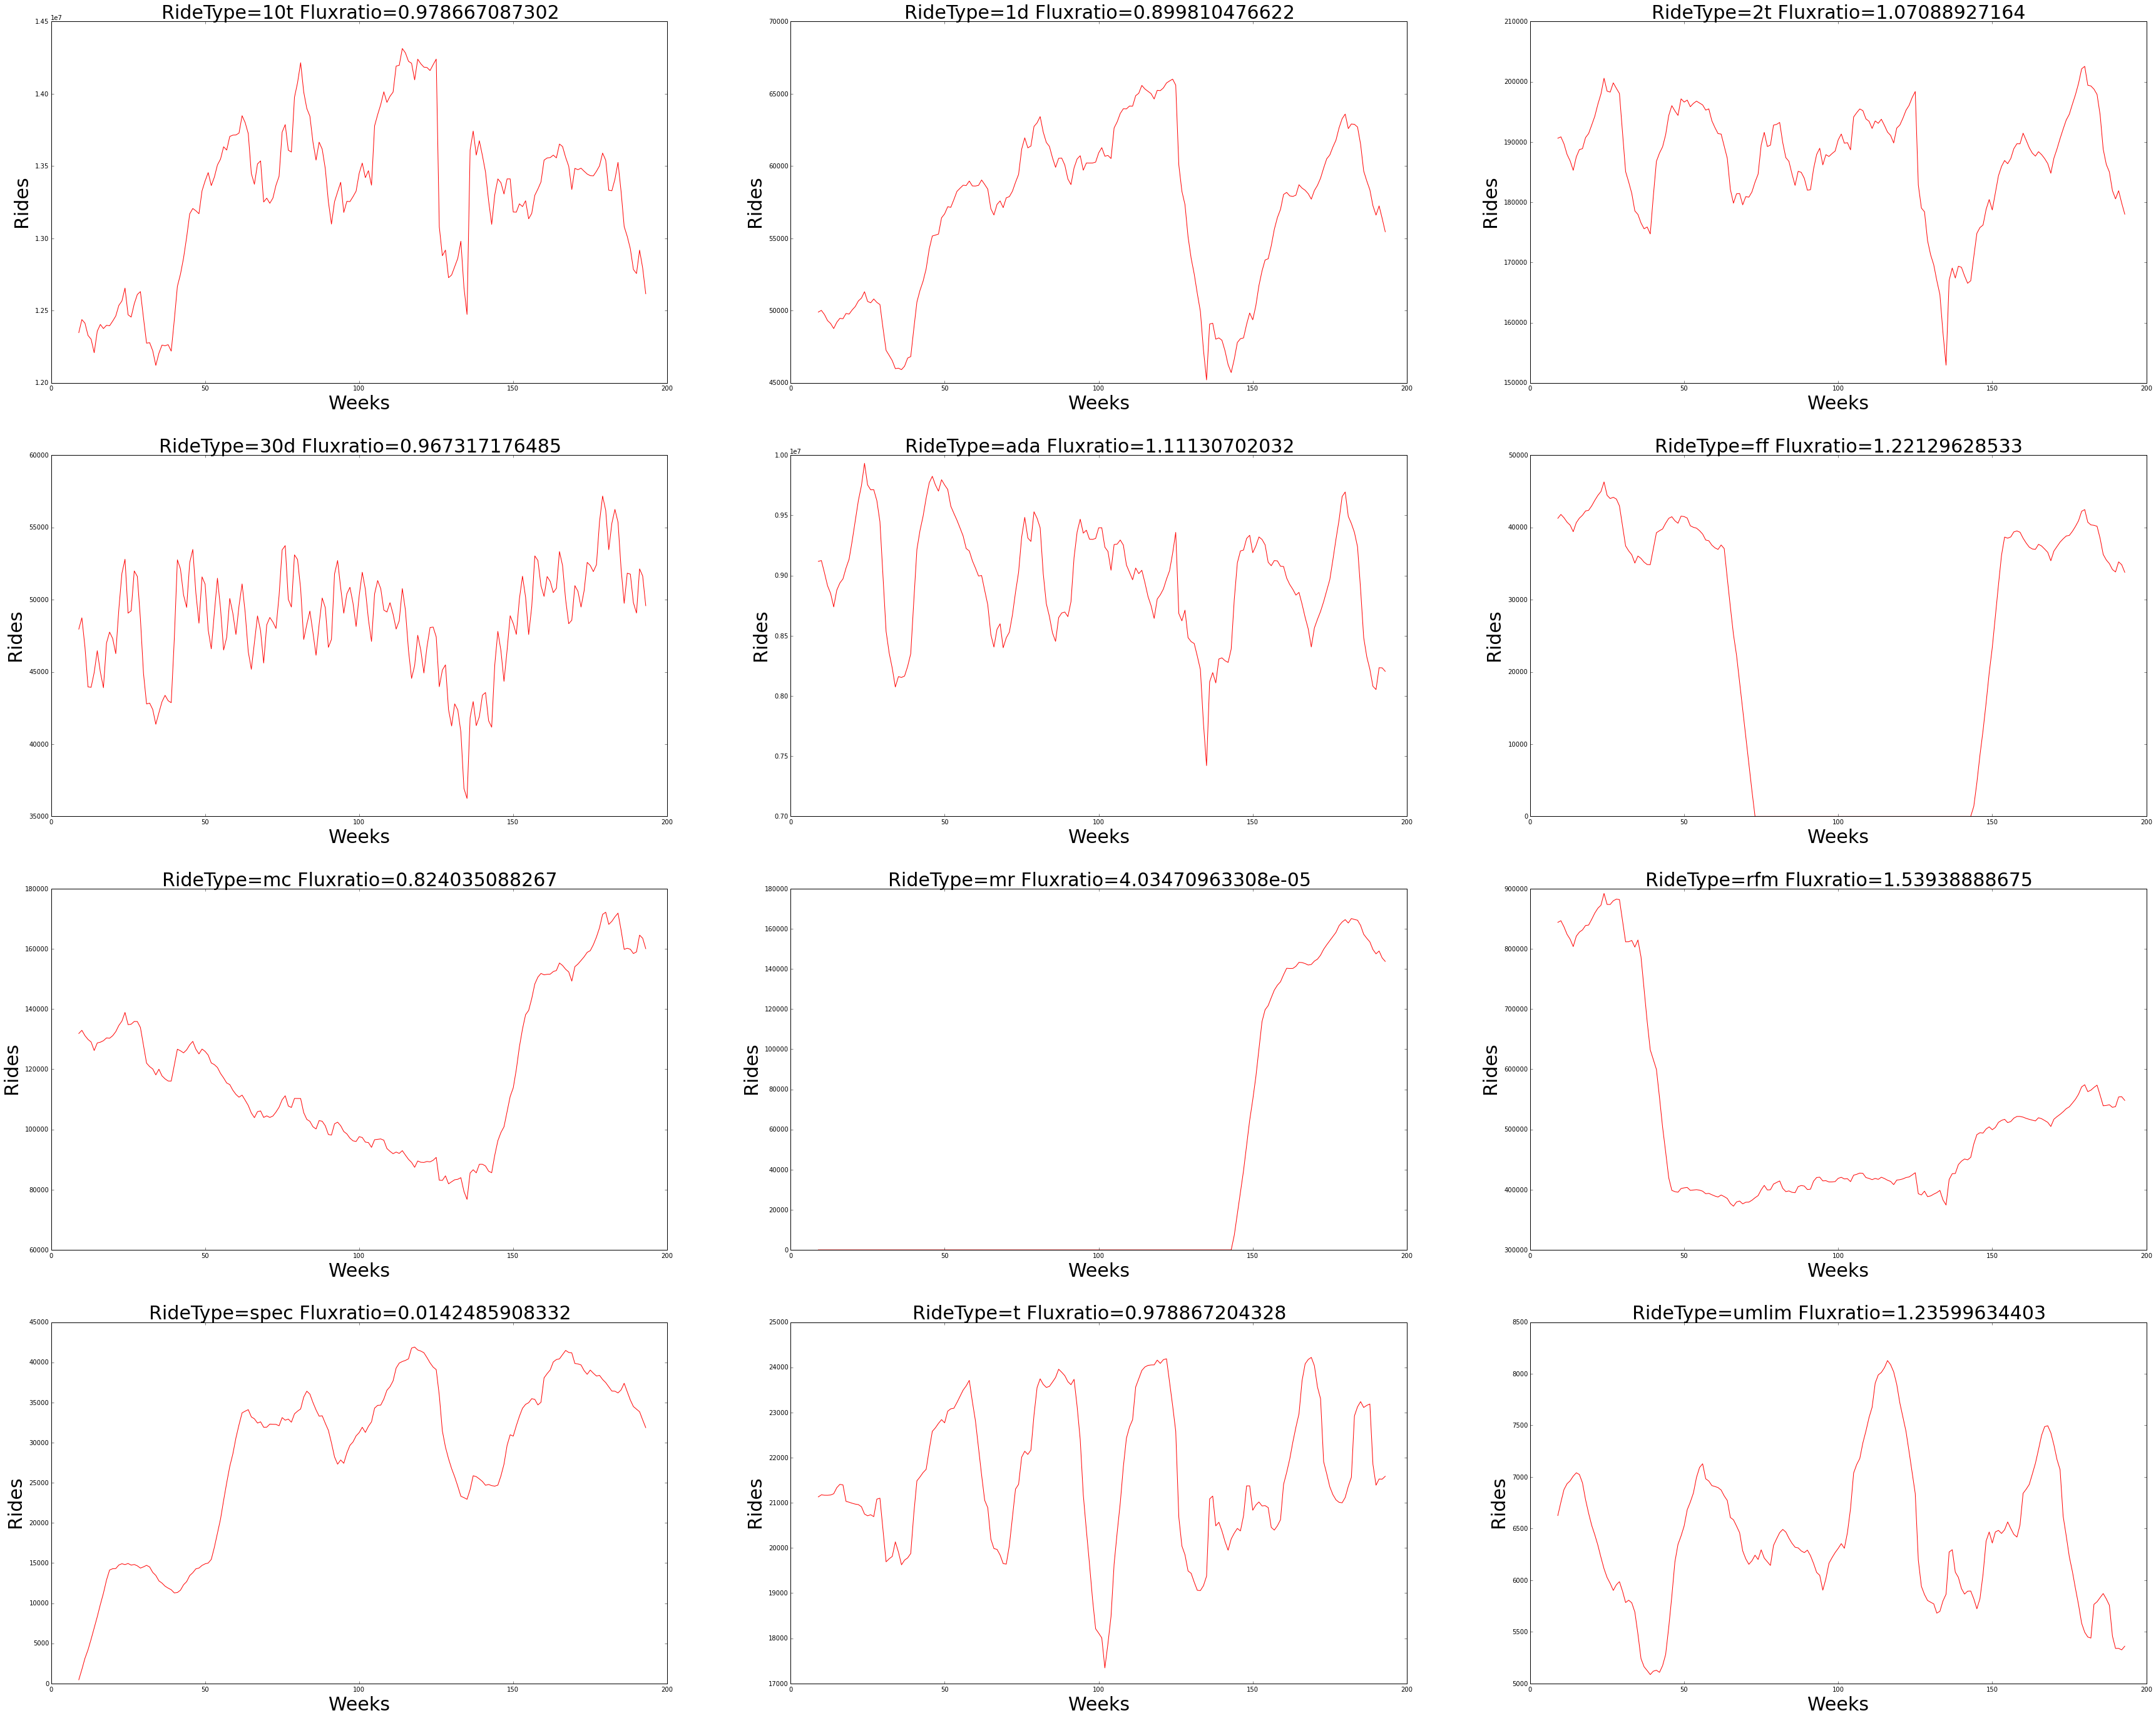

In [184]:
o = []
for i in range(0,23):
    if (flux_ratio[i] > 0 and flux_ratio[i]<=.3)|(flux_ratio[i] >=0.8 and flux_ratio[i] <= 1.7):
        o.append(i) 
fig = pl.figure(figsize=(60,60))      
for i in range(len(o)):
        print 'Use of %s passes have a complex structure.' % (ridetypes[o[i]])
        ax = fig.add_subplot(5,3,i+1)
        label1 = 'RideType=%s Fluxratio=%s' % (ridetypes[o[i]],flux_ratio[o[i]])
        ax.plot(pd.rolling_mean(ridertypes[ridetypes[o[i]]], 10), color ='r')
        ax.set_xlabel('Weeks', fontsize=30)
        ax.set_ylabel('Rides', fontsize=30)
        ax.set_title(label1, fontsize=30)


# Task 3:
Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

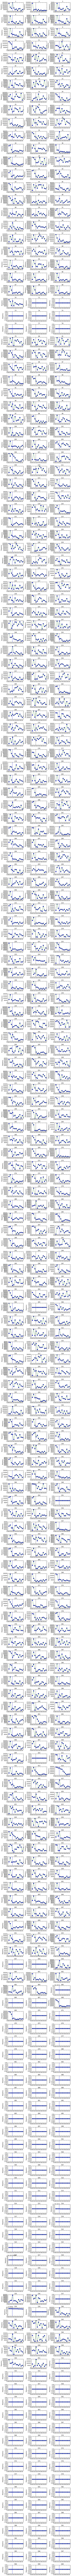

In [149]:
sum_stations = np.nansum(dataset, axis=(1))
sum_stations.shape

stations = pd.DataFrame(sum_stations)
stations.head()
fig=pl.figure(figsize=(10,400))


for i in range(0,600):
    ax = fig.add_subplot(200,3,i+1)
    f = np.abs(np.fft.rfft(stations.loc[i,:]))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms = 8)
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
    ax.set_xlim(0,1.0/15)
    ax.set_title(i+1)
    plt.axvline(1.0/52)
    pl.ylabel("frequency", fontsize=10)
    pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, bottom=.1)

In [160]:
# import operator
# sorted_periods = sorted(f.items(), key=operator.itemgetter(1))

# print("The Station's with the most prominent annual periodicity are")
# print(sorted_periods[594:600])
stations = range(0, 600)
periods = []
for i in range(600):
    periods.append(np.abs(np.fft.rfft(sum_stations[i]))[4])

annualTrend = pd.DataFrame({'stations':stations,
                           'frequency':periods})

annualTrend.sort('frequency', ascending=False).head(4)

# import operator
# sorted_periods = sorted(periods.items(), key=operator.itemgetter(1))

# print("The Station's with the most prominent annual periodicity are")
# print(sorted_periods[594:600])

frequency  stations
0    2980160.635595         0
194  2950388.929214       194
150  2931895.876951       150
327  2402218.580959       327

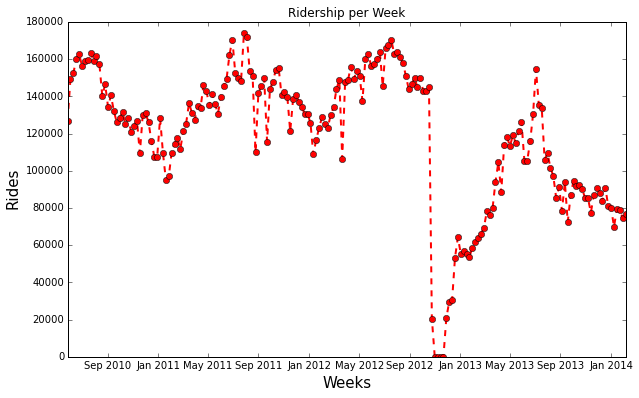

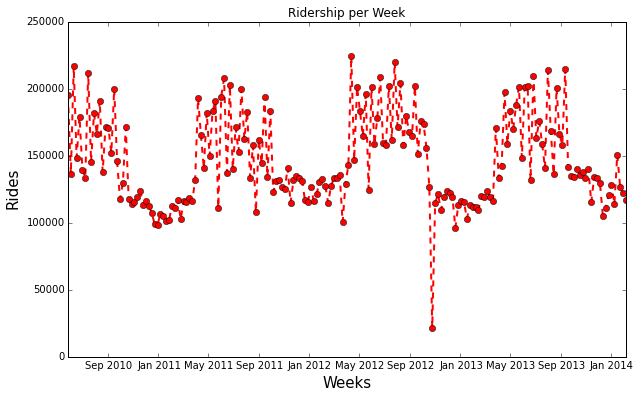

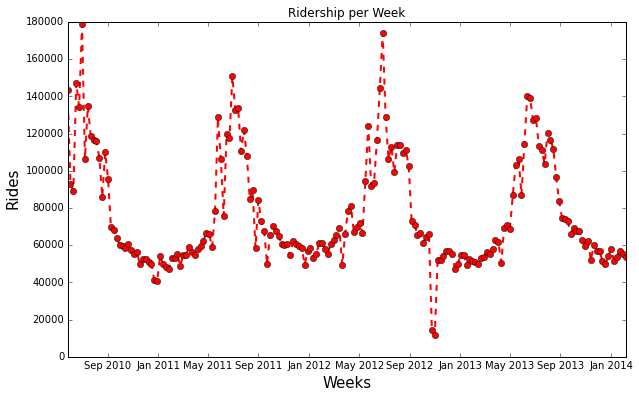

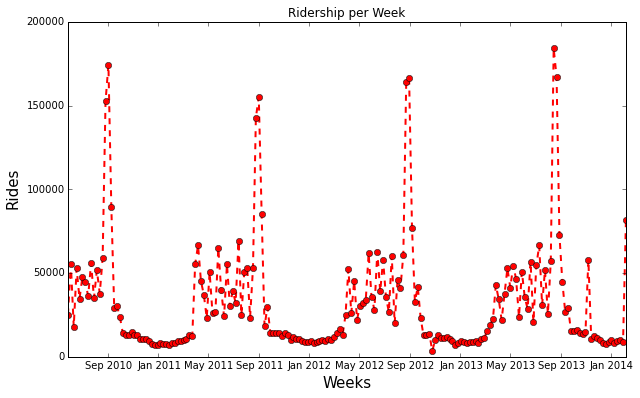

In [168]:
#Plotting time series for highest frequency
fig = pl.figure(figsize=(10,6))
pl.plot_date(week_generated,sum_stations[0],c='r', ls='--' , lw=2)
pl.xlabel('Weeks', fontsize=15)
pl.ylabel('Rides', fontsize=15)
pl.title('Ridership per Week')

fig = pl.figure(figsize=(10,6))
pl.plot_date(week_generated,sum_stations[194], c='r', ls='--' , lw=2)
pl.xlabel('Weeks', fontsize=15)
pl.ylabel('Rides', fontsize=15)
pl.title('Ridership per Week')

fig = pl.figure(figsize=(10,6))
pl.plot_date(week_generated,sum_stations[150], c='r', ls='--' , lw=2)
pl.xlabel('Weeks', fontsize=15)
pl.ylabel('Rides', fontsize=15)
pl.title('Ridership per Week')

fig = pl.figure(figsize=(10,6))
pl.plot_date(week_generated,sum_stations[327], c='r', ls='--' , lw=2)
pl.xlabel('Weeks', fontsize=15)
pl.ylabel('Rides', fontsize=15)
pl.title('Ridership per Week')

#### After identifying the 4 stations that show a prominent annual periodicity I identified the weeks of the year when we observe peaks in ridership increase is around the month of August. I think this increase is because of summer season, more tourists are visiting NY also kids have vacations so parents are taking them sightseeing. I also observed that the ridership noticibly increases in summer months, which again is agreeable. In summer more people are out shopping, doing leisure activities, enjoying the weather, but in winter people are generally using subway for necessity/daily activities. 

### EXTRA CREDIT

In [186]:
from sklearn.cluster import KMeans


In [187]:
# Impoting MTA_Fare File
data = np.load("MTA_Fare.npy")

data = np.array(dataset)
data = data.astype(numpy.float)

In [188]:
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
tots.shape

(13800L, 194L)

In [189]:
tots = tots[tots.std(1)>0]
tots.shape

(7660L, 194L)

In [190]:
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
vals.shape

(7660L, 194L)

In [191]:
km = KMeans(n_clusters=10)
km = km.fit(vals)


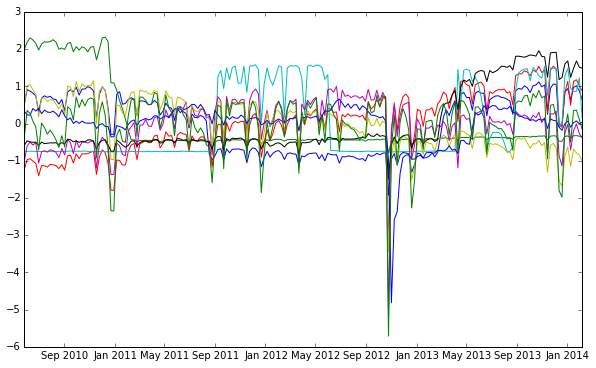

In [185]:
#Calculating average of timeseries in each cluster 
average = km.cluster_centers_
average.shape
average

# Plotting the average clusters
pl.figure(figsize=(10,6))
for i in range(9):
    pl.plot(week_generated, centroids[i])